<a href="https://colab.research.google.com/github/jennifervu6/surprisal-vp-np-japanese/blob/main/Surprisal_of_VPs_and_Case_Marked_NPs_in_Japanese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Surprisal of VPs and Case-Marked NPs in Japanese
This is part of an individual research project for LIGN 169: Information Theory at UCSD. This project will explore the average surprisal of verb phrases (VPs), and the average surprisal of case-marked NPs, both in Japanese. Additionally, we will compare these with these same surprisals in English to identify a unique property of Japanese grammar.

The project first needs a treebank that needs to be parsed through. To analyze the data, I've imported the Japanese-PUD treebank to parse through and extract phrases and find surprisal values. Additionally, I've used the PUD treebank instead of Japanese-GSD is to later compare the surprisals of Japanese and English to see if there is anything greater to uncover about sentence processing using surprisal.

Note: This treebank is written in Kanji

### Imports
Importing necessary python libraries

In [ ]:
!pip install conllu

In [ ]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from conllu import parse

Loading a medium-sized Japanese GPT-2 model (rinna/japanese-gpt2-medium). I used the code from Hugging Face, but I turned it into a function so I can call it later.

In [ ]:
def load_model_ja():
  model_name = "rinna/japanese-gpt2-medium"
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForCausalLM.from_pretrained(model_name)
  return tokenizer, model

Reading the Japanese PUD Universal Dependencies file

In [ ]:
conllu_file = open("/content/ud_files/ja_pud-ud-test.conllu").read()
print(conllu_file[:3400])

# newdoc id = n01001
# sent_id = n01001011
# text = 「米国でデジタルへの移行が大いに進んでいる一方で、権力の平和的な移行は進んでいない」と書いたブログを、オバマ大統領特別補佐コリ・シューマンが月曜日に投稿した。
# text_en = “While much of the digital transition is unprecedented in the United States, the peaceful transition of power is not,” Obama special assistant Kori Schulman wrote in a blog post Monday.
1	「	「	PUNCT	補助記号-括弧開	_	2	punct	_	BunsetuBILabel=B|BunsetuPositionType=CONT|LUWBILabel=B|LUWPOS=補助記号-括弧開|SpaceAfter=No|UnidicInfo=,「,「,「,,,,,,「
2	米国	米国	PROPN	名詞-固有名詞-地名-国	_	10	obl	_	BunsetuBILabel=I|BunsetuPositionType=SEM_HEAD|LUWBILabel=B|LUWPOS=名詞-固有名詞-地名-国|SpaceAfter=No|UnidicInfo=ベイコク,米国,米国,米国,ベーコク,,,ベイコク,ベイコク,米国
3	で	で	ADP	助詞-格助詞	_	2	case	_	BunsetuBILabel=I|BunsetuPositionType=SYN_HEAD|LUWBILabel=B|LUWPOS=助詞-格助詞|SpaceAfter=No|UnidicInfo=デ,で,で,で,デ,,,デ,デ,で
4	デジタル	デジタル	NOUN	名詞-普通名詞-形状詞可能	_	7	nmod	_	BunsetuBILabel=B|BunsetuPositionType=SEM_HEAD|LUWBILabel=B|LUWPOS=名詞-普通名詞-一般|SpaceAfter=No|UnidicInfo=デジタル,デジタル,デジタル,デジタル,デジタル,,,デジタル,デジタル,デジタル
5	へ	へ	ADP	助詞-格助詞	_	4	

Here is an example of a parsed sentence using Co-NLLu

In [ ]:
def parse_conllu_file(filepath):
    with open(filepath) as f:
        conllu_data = f.read()
    sentences = parse(conllu_data)
    return sentences

In [ ]:
# This part of the code shows the first sentence and how it is parsed
sentence_file = open("/content/ud_files/ja_pud-ud-test.txt").read()
sentences = sentence_file.split('\n\n')
first_sentence = sentences[0]
list = parse(conllu_file)
first_sentence, list[1][0]

('「米国でデジタルへの移行が大いに進んでいる一方で、権力の平和的な移行は進んでいない」と書いたブログを、オバマ大統領特別補佐コリ・シューマンが月曜日に投稿した。ワシ\nントンのキャピトルヒルでソーシャルメディアの移行をフォローした人にとっては、このことは少し違う。 ',
 {'id': 1,
  'form': 'ワシントン',
  'lemma': 'ワシントン',
  'upos': 'PROPN',
  'xpos': '名詞-固有名詞-地名-一般',
  'feats': None,
  'head': 4,
  'deprel': 'nmod',
  'deps': None,
  'misc': {'BunsetuBILabel': 'B',
   'BunsetuPositionType': 'SEM_HEAD',
   'LUWBILabel': 'B',
   'LUWPOS': '名詞-固有名詞-地名-一般',
   'SpaceAfter': 'No',
   'UnidicInfo': 'ワシントン,ワシントン,ワシントン,ワシントン,ワシントン,,,ワシントン,ワシントン,ワシントン'}})

## Part 1: Looking at the surprisal of Verb Phrases (VPs)
Japanese typically follows an SOV structure, so verbs appear after its object argument. However, the word order is flexible, so adjuncts/complements can be placed either before or after verbs, and subjects can be grammatical even if it appears in the middle of the sentence. For this part, we will only look at surprisal on an average, so we won't account for flexibility,

Inputting the general surprisal calculation function

In [ ]:
# prompt: a function to calculate the average surprisal of a sentence with GPT2 using numpy
def calculate_surprisal(model, tokenizer, sentence):
    """Calculate the average surprisal (-log2 probability) of a sentence."""
    input_ids = tokenizer.encode(sentence, return_tensors="pt")

    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits

    log_probs = torch.log_softmax(logits, dim=-1)  # Convert logits to log probabilities
    token_probs = log_probs[0, torch.arange(len(input_ids[0])), input_ids[0]]
    surprisals = -token_probs / np.log(2)  # Convert natural log to log base 2

    return surprisals.mean().item()  # Return average surprisal

Computing the average surprisal values for verb phrases (upos: VERB). The function below takes all tokens that is a verb, then finds its dependents to create a verb phrase, and uses the model to calculate the average surprisal for all verb phrases in the treebank.

In [ ]:
# prompt: with def load_model():, make a function that looks at the surprisal of verb phrases and parse with conllu parse
def extract_vp_surprisal(conllu_file, tokenizer, model):
    """Extract verb phrases (VPs) and compute their average surprisal."""
    with open(conllu_file, "r", encoding="utf-8") as f:
        sentences = parse(f.read())

    vp_surprisals = []

    for sentence in sentences:
        words = {token["id"]: token["form"] for token in sentence}

        for token in sentence:
            if token["upos"] == "VERB":  # Check if token is a verb
                head_id = token["head"]  # Get the head of the verb
                phrase = [token["form"]]  # Start VP with the verb

                # Find dependents of the verb to complete the VP
                for dep in sentence:
                    if dep["head"] == token["id"]:  # If the token depends on the verb
                        phrase.append(dep["form"])

                vp_sentence = " ".join(phrase)  # Form VP phrase
                surprisal = calculate_surprisal(model, tokenizer, vp_sentence)
                vp_surprisals.append(surprisal)

    return np.mean(vp_surprisals) if vp_surprisals else None  # Return average VP surprisal

In [ ]:
# executing the function (this whole thing takes about 18 minutes)
tokenizer, model = load_model_ja()
conllu_file = "/content/ud_files/ja_pud-ud-test.conllu"

#computing the average VP surprisal in Japanese
vp_avg_surprisal_ja = extract_vp_surprisal(conllu_file, tokenizer, model)
print("Average Surprisal of Verb Phrases:", vp_avg_surprisal_ja)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/806k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/153 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Average Surprisal of Verb Phrases: 12.550986348360109


## Part 2: Surprisal of case marked Noun Phrases (NPs)

Japanese uses a very detailed case marking system. For the project, we will look at nominative (NOM), accusative (ACC), dative (DAT), and genitive (POSS). These markers in Japanese are が 'ga', を 'wo', に 'ni', and の: 'no' respectively.  The function below will compute the average surprisal values for these three case markers, starting by taking in nouns from a treebank, finding its dependents to create NPs, and calculating the surprisal, on average, of these NPs depending on their case.

In [ ]:
# prompt: create a function that extracts NPs from a treebank and take an average surprisal of the nominative case, the accusative case, the dative case, and the possessive case
def extract_np_surprisal_ja(conllu_file, tokenizer, model):
    """Extract noun phrases (NPs) and compute their average surprisal by case marker."""
    with open(conllu_file, "r", encoding="utf-8") as f:
        sentences = parse(f.read())

    case_markers = {"が": "NOM", "を": "ACC", "に": "DAT", "の": "POSS"}
    np_surprisals = {"NOM": [], "ACC": [], "DAT": [], "POSS":[]}

    for sentence in sentences:
        words = {token["id"]: token["form"] for token in sentence}

        for token in sentence:
            if token["upos"] in {"NOUN", "PROPN", "PRON"}:  # Check if token is an NP head
                np_phrase = [token["form"]]  # Start NP phrase
                np_case = None  # Case marker

                # Find case marking particle attached to NP
                for dep in sentence:
                    if dep["head"] == token["id"] and dep["upos"] == "ADP":
                        case_marker = dep["form"]
                        if case_marker in case_markers:
                            np_case = case_markers[case_marker]
                            np_phrase.append(case_marker)
                            break  # Stop once case marker is found

                if np_case:
                    np_sentence = " ".join(np_phrase)  # Form NP phrase
                    surprisal = calculate_surprisal(model, tokenizer, np_sentence)
                    np_surprisals[np_case].append(surprisal)

    # Compute averages
    avg_surprisals = {case: (np.mean(vals) if vals else None) for case, vals in np_surprisals.items()}
    return pd.DataFrame.from_dict(avg_surprisals, orient="index", columns=["Avg Surprisal"])

In [ ]:
tokenizer, model = load_model_ja()
conllu_file = "/content/ud_files/ja_pud-ud-test.conllu"

#computing average surprisal for case-marked NPs
np_avg_surprisal_ja = extract_np_surprisal_ja(conllu_file, tokenizer, model)
print(np_avg_surprisal_ja)

      Avg Surprisal
NOM       12.681265
ACC       12.968717
DAT       12.981359
POSS      12.667602


From the given data, it seems like nominative NPs have slightly less surprisal than accusative and dative case. Accusative and dative NPs seem to have very similar surprisals.

##Part 3: Looking at English VPs and NPs
To compare the surprisal values we found above to English phrases, I've imported UD-English-PUD into the project for comparison. As mentioned, PUD treebanks are specifically created to compare two languages together.

We also have to load a smaller GPT-2 model for English! I am using the OpenAI Community GPT-2 model. This model is trained on a really large corpus.

In [ ]:
def load_model_en():
  tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
  model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
  return tokenizer, model

Finding the averages for English VPs

In [ ]:
def extract_vp_surprisal_en(conllu_file, tokenizer, model):
    with open(conllu_file, "r", encoding="utf-8") as f:
        sentences = parse(f.read())

    vp_surprisals = []

    for sentence in sentences:
        words = {token["id"]: token["form"] for token in sentence}

        for token in sentence:
            if token["upos"] == "VERB":  # Check if token is a verb
                head_id = token["head"]  # Get the head of the verb
                phrase = [token["form"]]  # Start VP with the verb

                # Find dependents of the verb to complete the VP
                for dep in sentence:
                    if dep["head"] == token["id"]:  # If the token depends on the verb
                        phrase.append(dep["form"])

                vp_sentence = " ".join(phrase)  # Form VP phrase
                surprisal = calculate_surprisal(model, tokenizer, vp_sentence)
                vp_surprisals.append(surprisal)

    return np.mean(vp_surprisals) if vp_surprisals else None  # Return average VP surprisal

In [ ]:
tokenizer, model = load_model_en()
en_conllu_file = "/content/ud_files/en_pud-ud-test.conllu"
# Computing the average surprisal in English
vp_avg_surprisal_en = extract_vp_surprisal(conllu_file, tokenizer, model)
print("Average Surprisal of Verb Phrases:", vp_avg_surprisal_en)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Average Surprisal of Verb Phrases: 13.88875234010431


English does not have much of a case marking system, beside its pronouns. For this part of the comparison, we will only look at nominative, accusative, and genitive (possessive) case in English, and for the sake of time, we are only looking at case based on English pronouns.

In [ ]:
# prompt: create a function that calculates the average surprisals of noun phrases in english, but sort these out by nominative, accusative, and possessive case

def extract_np_surprisal_english(conllu_file, tokenizer, model):
    """Extract noun phrases (NPs) in English and compute their average surprisal by case type."""
    with open(conllu_file, "r", encoding="utf-8") as f:
        sentences = parse(f.read())

    # Define case categories based on common English pronouns
    case_markers = {
        "NOM": {"I", "he", "she", "we", "they", "who"},
        "ACC": {"me", "him", "her", "us", "them", "whom"},
        "POSS": {"my", "his", "her", "our", "their", "whose"}
    }

    np_surprisals = {"NOM": [], "ACC": [], "POSS": []}

    for sentence in sentences:
        words = {token["id"]: token["form"].lower() for token in sentence}  # Store lowercase words for lookup

        for token in sentence:
            if token["upos"] in {"NOUN", "PROPN", "PRON"}:  # Check if token is an NP head
                np_phrase = [token["form"]]  # Start NP phrase
                np_case = None  # Case type

                # Determine case based on pronoun list
                if token["form"].lower() in case_markers["NOM"]:
                    np_case = "NOM"
                elif token["form"].lower() in case_markers["ACC"]:
                    np_case = "ACC"
                elif token["form"].lower() in case_markers["POSS"]:
                    np_case = "POSS"

                # If we detected a case, calculate surprisal
                if np_case:
                    np_sentence = " ".join(np_phrase)  # Form NP phrase
                    surprisal = calculate_surprisal(model, tokenizer, np_sentence)
                    np_surprisals[np_case].append(surprisal)

    # Compute average surprisals
    avg_surprisals = {case: (np.mean(vals) if vals else None) for case, vals in np_surprisals.items()}
    return pd.DataFrame.from_dict(avg_surprisals, orient="index", columns=["Avg Surprisal"])


In [ ]:
tokenizer, model = load_model_en()
conllu_file = "/content/ud_files/en_pud-ud-test.conllu"

# Compute average surprisal for case-marked NPs
np_avg_surprisal_en = extract_np_surprisal_english(conllu_file, tokenizer, model)
print(np_avg_surprisal_en)

      Avg Surprisal
NOM       12.806327
ACC       12.492579
POSS      15.493194


## Conclusion

### Comparison of Verb Phrase Surprisal in Japanese and English

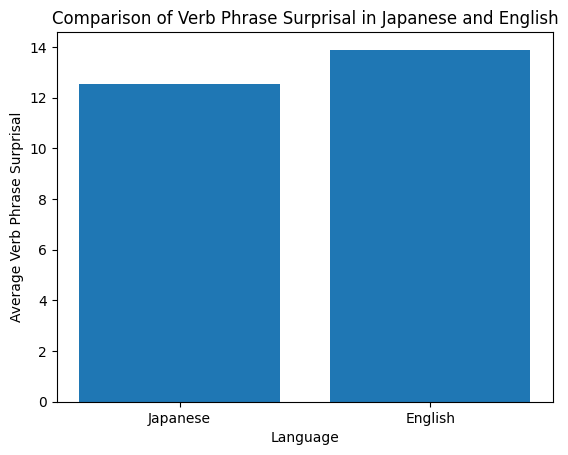

In [ ]:
# creating data for the bar graphs of VP surprisal
languages = ['Japanese', 'English']
vp_surprisals = [vp_avg_surprisal_ja, vp_avg_surprisal_en]

plt.bar(languages, vp_surprisals)
plt.xlabel('Language')
plt.ylabel('Average Verb Phrase Surprisal')
plt.title('Comparison of Verb Phrase Surprisal in Japanese and English')
plt.show()

From the bar graph, we can see that the surprisal of Japanese VP surprisal is a little lower than English. While we don't know if this is statistically significant, this follows the prediction I had earlier that Japanese VPs might have less surprisal than English due to its word order. Japanese follows an SOV word order, so the intuition was that surprisal would be lower here because the indication of an object would narrow down the possibilities of a specific verb occurring — making the probability of any given verb occuring higher, and the surprisal lower.

### Comparison of Case-marked Noun Phrase Surprisal in Japanese and English

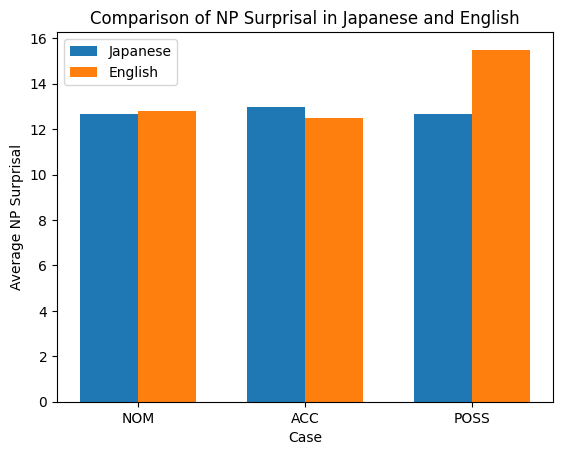

In [ ]:
# prompt: with matplotlib, create data for the bar graphs of NP surprisal (NOM, ACC, POSS) in japanese and english

# Sample data (replace with your actual data from np_avg_surprisal_ja and np_avg_surprisal_en)
ja_np_surprisals = {'NOM': 12.681265, 'ACC': 12.968717, 'POSS': 12.667602}
en_np_surprisals = {'NOM': 12.806325, 'ACC': 12.492578, 'POSS': 15.493181}

# Create data for the bar graph
cases = ['NOM', 'ACC', 'POSS']
japanese_data = [ja_np_surprisals[case] for case in cases]
english_data = [en_np_surprisals[case] for case in cases]

# Set the width of the bars
bar_width = 0.35

# Create the x positions for the bars
x_pos = np.arange(len(cases))

# Create the bar graph
fig, ax = plt.subplots()
rects1 = ax.bar(x_pos - bar_width/2, japanese_data, bar_width, label='Japanese')
rects2 = ax.bar(x_pos + bar_width/2, english_data, bar_width, label='English')

# Add labels and title
ax.set_xlabel('Case')
ax.set_ylabel('Average NP Surprisal')
ax.set_title('Comparison of NP Surprisal in Japanese and English')
ax.set_xticks(x_pos)
ax.set_xticklabels(cases)
ax.legend()

# Display the graph
plt.show()


It seems like the average surprisal for the nominative cases in Japanese and English are roughly the same, and this might be in part of the nominative case, usually associated with subjects, are always at the beginning of the sentence.
Although, the surprisal value for the accusative case is a little higher in Japanese than it is in English. English accusative case may come less as a surprise because the case is already embedded into the noun/pronoun. Overall, the difference is not as much.

The surprisal of the genitive NP is a lot higher in English than it is in Japanese. A speculated reason why is due to possession in English usually comes after a noun or proper noun, ('s). A speaker may not realize that this is coming, rather than a case marking that comes before the NP, like in Japanese.